In [6]:
import numpy as np
import os
import cv2
import sys
import h5py
import hdf5storage
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, jaccard_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import numpy as np


from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K # make sure all K are capital
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, jaccard_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'h5py'

In [ ]:
path = '/Users/elizabethnemeti/Desktop/' # local runs
data_dir = os.path.join(path, 'data') # local runs
# data_dir = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/data' # cluster runs

if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"No such directory: {data_dir}") # debug check

files = os.listdir(data_dir)
print(f"Files in {data_dir}:", files) # should see the 3064 mat files

In [3]:
###Load and preprocess data

def load_and_preprocess_data(data_dir, image_dimension):
    images = []
    masks = []
    labels = []  # Store labels to check distribution
    files = os.listdir(data_dir)
    # Data integrity check
    print(f"Total files found: {len(files)}")
    processed_count = 0
    
    
    for i, file in enumerate(files, start=1):
        try:
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0] # Load the .mat file
            
            # Resize and normalize the images
            image = mat_file['image']
            image = cv2.resize(image, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC)
            image = image.astype(np.float32) / 255.0  # Scale image to range [0, 1]
            image = np.expand_dims(image, axis=-1)  # Add the channel dimension (fprep or check later)
            
            # Resize and prepare mask for multi-class segmentation
            mask = mat_file['tumorMask'].astype('uint8')
            mask = cv2.resize(mask, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)  # Add the channel dimension (prep for check later)
            
            # Get the label and convert to one-hot
            label = int(mat_file['label'])  # assuming label is directly accessible
            one_hot_mask = np.zeros((image_dimension, image_dimension, 3), dtype=np.float32)  # three classes # set dtype to float32
            for j in range(1, 4):  # labels are 1, 2, 3
                one_hot_mask[:, :, j-1] = (mask[:, :, 0] == j).astype(np.float32)  # Cast to float32
                
            # Append processed image and mask to their respective lists
            images.append(image)
            masks.append(one_hot_mask)
            
            #masks.append(mask)
            labels.append(label)
            processed_count += 1
            if i % 10 == 0:
                sys.stdout.write(f'\r[{i}/{len(files)}] images loaded: {i / float(len(files)) * 100:.1f} %')
                sys.stdout.flush()
        except Exception as e:
            print(f"Failed to process file {file}: {e}")
    print(f"\nFinished loading and processing data. Successfully processed {processed_count}/{len(files)} files.")
    return np.array(images), np.array(masks), np.array(labels)


###Show sample images to double check

def visualize_sample_images(images, masks, labels, num_samples=5):
    """Visual inspection of images and masks, with labels indicating tumor type."""
    # Mapping of label numbers to tumor names
    label_to_tumor = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i in indices:
        # Get tumor type from label
        tumor_type = label_to_tumor.get(labels[i], "Unknown Tumor Type")
        title = f"Sample Image {i+1} - Label: {tumor_type} ({labels[i]})"
        show_image_and_mask(images[i], masks[i], title)
        
 #check distribution for tumor types     

def check_data_distribution(labels):
    """Check for class distribution across different tumor types."""
    from collections import Counter
    label_counts = Counter(labels)
    total_counts = len(labels)
    for label, count in label_counts.items():
        print(f"Label {label} (Type): {count} slices, {count / total_counts * 100:.2f}% of the dataset")

        
###display one image and its ground truth mask  

def show_image_and_mask(image, mask, title):
    """Displays an image and its corresponding mask side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(mask, cmap='viridis')
    ax[1].set_title('Ground Truth Mask')
    plt.suptitle(title)
    plt.show()
    
###data_dir = '/Users/elizabethnemeti/Desktop/data' # local runs
# data_dir = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/data' # cluster runs

image_dimension = 128

# Func to load and preprocess the data
images, masks, labels = load_and_preprocess_data(data_dir, image_dimension)

# Visualization for sample images and masks
visualize_sample_images(images, masks, labels, num_samples=3)

# Check data distribution for class imbalance
check_data_distribution(labels)

# Check data types of masks and predictions to make sure they're both float32

print(f"Data type of image: {images.dtype}")
print(f"Data type of masks: {masks.dtype}")

NameError: name 'data_dir' is not defined

In [1]:
def split_data(images, masks, labels, test_size=0.2, val_size=0.25, random_state=None):
    # Split the data into training and testing sets
    images_train_val, images_test, masks_train_val, masks_test, labels_train_val, labels_test = train_test_split(
        images, masks, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    # Further split into training and validation sets
    images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
        images_train_val, masks_train_val, labels_train_val, test_size=val_size/(1-test_size), random_state=random_state)
    
    return images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test

def visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test):
    """Display the first image and mask from training, validation, and testing sets."""
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(images_train[0], cmap='gray')
    axes[0].set_title('Training Image')
    axes[1].imshow(masks_train[0], cmap='viridis')
    axes[1].set_title('Training Mask')
    axes[2].imshow(images_val[0], cmap='gray')
    axes[2].set_title('Validation Image')
    axes[3].imshow(masks_val[0], cmap='viridis')
    axes[3].set_title('Validation Mask')
    axes[4].imshow(images_test[0], cmap='gray')
    axes[4].set_title('Testing Image')
    plt.show()
    
#Check distribution

def check_distribution(labels, title="Label distribution"):
    """Print the distribution of labels."""
    unique, counts = np.unique(labels, return_counts=True)
    label_dict = dict(zip(unique, counts))
    print(f"{title}: {label_dict}")

# Split the data into training, validation, and testing sets
images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test = split_data(images, masks, labels, test_size=0.2, val_size=0.25)

# Visualization for the first training, validation, and testing images
visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test)

# Check label distributions
check_distribution(labels, "Total Label Distribution")
check_distribution(labels_train, "Training Label Distribution")
check_distribution(labels_val, "Validation Label Distribution")
check_distribution(labels_test, "Testing Label Distribution")

# DEBUG: Check data types -- see code from Elizabeth
print(f"Data type of images_train: {images_train.dtype}")
print(f"Data type of masks_train: {masks_train.dtype}")
print(f"Data type of labels_train: {labels_train.dtype}")
print(f"Data type of images_val: {images_val.dtype}")
print(f"Data type of masks_val: {masks_val.dtype}")
print(f"Data type of labels_val: {labels_val.dtype}")
print(f"Data type of images_test: {images_test.dtype}")
print(f"Data type of masks_test: {masks_test.dtype}")
print(f"Data type of labels_test: {labels_test.dtype}")

In [17]:
def check_dimensions(images, masks, required_image_shape, required_mask_shape):
    """
    Validate if the images and masks match the required dimensions.
    - images and masks are the datasets to check.
    - required_image_shape and required_mask_shape are tuples representing the required dimensions.
    """
    # For SVM classification, we don't need masks, so we only check image dimensions
    assert images.shape[1:] == required_image_shape, f"Image shape mismatch: expected {required_image_shape}, got {images.shape[1:]}"
    print(f"Image shape is {images.shape[1:]}")
    print("All images correctly match the required shape.")

# Required shape for SVM
required_image_shape = (image_dimension, image_dimension, 1)  # This is for images, which are grayscale and should have a single channel explicitly.

# Assuming 'images' is the dataset used for SVM training and validation
check_dimensions(images, None, required_image_shape, None)

Image shape is (128, 128, 1)
All images correctly match the required shape.


In [19]:
# Initialize lists to store evaluation metrics for each kernel
kernel_names = ['rbf', 'linear', 'sigmoid']
evaluation_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'jaccard_index': [],
    'f1_score': [],
    'dice_similarity': [],
    'specificity': []
}

# Perform k-fold cross-validation for each kernel
for kernel in kernel_names:
    print(f"Evaluating SVM with {kernel} kernel...")
    
    # Initialize StratifiedKFold for current kernel
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize lists to store evaluation metrics for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    jaccard_scores = []
    f1_scores = []
    dice_similarity_scores = []
    specificity_scores = []
    
    # Loop over folds
    for train_index, val_index in skf.split(images, labels):
        X_train, X_val = images[train_index], images[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        
        # Initialize model with current kernel
        svm_model = SVC(kernel=kernel, C=1.0, random_state=42)
        
        # Train the model
        svm_model.fit(X_train.reshape(len(X_train), -1), y_train)
        
        # Make predictions on the validation set
        y_val_pred = svm_model.predict(X_val.reshape(len(X_val), -1))
        
        # Compute evaluation metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, average='weighted')
        recall = recall_score(y_val, y_val_pred, average='weighted')
        jaccard_index = jaccard_score(y_val, y_val_pred, average='weighted')
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1:].sum()
        fn = conf_matrix[1:, 0].sum()
        dice_similarity = (2 * tn) / (2 * tn + fp + fn)
        specificity = tn / (tn + fp)
        
        # Append evaluation metrics to lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        jaccard_scores.append(jaccard_index)
        f1_scores.append(f1)
        dice_similarity_scores.append(dice_similarity)
        specificity_scores.append(specificity)
    
    # Compute average evaluation metrics for the current kernel
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_jaccard = np.mean(jaccard_scores)
    avg_f1 = np.mean(f1_scores)
    avg_dice_similarity = np.mean(dice_similarity_scores)
    avg_specificity = np.mean(specificity_scores)
    
    # Print average evaluation metrics for the current kernel
    print(f"Average Accuracy ({kernel}):", avg_accuracy)
    print(f"Average Precision ({kernel}):", avg_precision)
    print(f"Average Recall ({kernel}):", avg_recall)
    print(f"Average Jaccard Index ({kernel}):", avg_jaccard)
    print(f"Average F1 Score ({kernel}):", avg_f1)
    print(f"Average Dice Similarity ({kernel}):", avg_dice_similarity)
    print(f"Average Specificity ({kernel}):", avg_specificity)
    print()
    
    # Store average evaluation metrics for the current kernel
    evaluation_metrics['accuracy'].append(avg_accuracy)
    evaluation_metrics['precision'].append(avg_precision)
    evaluation_metrics['recall'].append(avg_recall)
    evaluation_metrics['jaccard_index'].append(avg_jaccard)
    evaluation_metrics['f1_score'].append(avg_f1)
    evaluation_metrics['dice_similarity'].append(avg_dice_similarity)
    evaluation_metrics['specificity'].append(avg_specificity)

# Print overall average evaluation metrics across all kernels
print("Overall Average Evaluation Metrics:")
for metric, values in evaluation_metrics.items():
    avg_metric = np.mean(values)
    print(f"Average {metric}: {avg_metric}")


Evaluating SVM with rbf kernel...
Average Accuracy (rbf): 0.8305127635960045
Average Precision (rbf): 0.8448952274129968
Average Recall (rbf): 0.8305127635960045
Average Jaccard Index (rbf): 0.71217461492245
Average F1 Score (rbf): 0.8272516790651558
Average Dice Similarity (rbf): 0.786244434940842
Average Specificity (rbf): 0.8602237538707422

Evaluating SVM with linear kernel...
Average Accuracy (linear): 0.8074539400665927
Average Precision (linear): 0.8106941560938349
Average Recall (linear): 0.8074539400665927
Average Jaccard Index (linear): 0.6885388999437747
Average F1 Score (linear): 0.8068357183728194
Average Dice Similarity (linear): 0.7418486673088179
Average Specificity (linear): 0.7854260313654979

Evaluating SVM with sigmoid kernel...
Average Accuracy (sigmoid): 0.5291997780244173
Average Precision (sigmoid): 0.523982124858428
Average Recall (sigmoid): 0.5291997780244173
Average Jaccard Index (sigmoid): 0.3601972355194357
Average F1 Score (sigmoid): 0.5192822672310885
Ave

# Visualize Evaluation Metrics Across Kernels Validation Dataset 

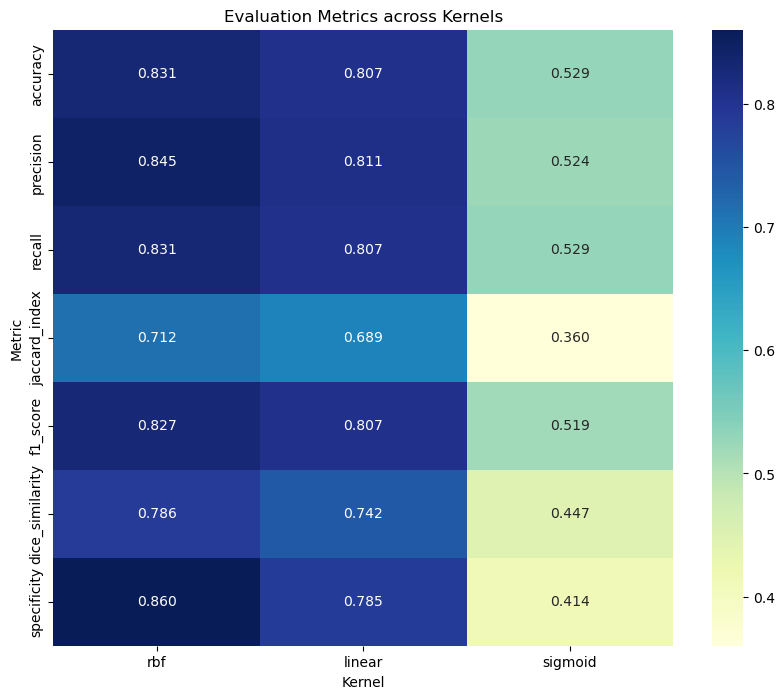

In [30]:
# Create heatmap to visualize all metrics across kernels
metric_values = np.array([evaluation_metrics[metric] for metric in metrics])

plt.figure(figsize=(10, 8))
sns.heatmap(metric_values, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=kernel_names, yticklabels=metrics)
plt.title('Evaluation Metrics across Kernels')
plt.xlabel('Kernel')
plt.ylabel('Metric')
plt.show()

# K-Fold validation on RBF KERNEL

In [20]:
# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Perform k-fold cross-validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
jaccard_scores = []
f1_scores = []
dice_similarity_scores = []
specificity_scores = []

for train_index, val_index in skf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]
    
    # Your SVM model training code here
    svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
    svm_model.fit(X_train.reshape(len(X_train), -1), y_train)
    
    # Evaluation 
    y_val_pred = svm_model.predict(X_val.reshape(len(X_val), -1))
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')
    jaccard_index = jaccard_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    tn = conf_matrix[0, 0]
    fp = conf_matrix[0, 1:].sum()
    fn = conf_matrix[1:, 0].sum()
    dice_similarity = (2 * tn) / (2 * tn + fp + fn)
    specificity = tn / (tn + fp)
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    jaccard_scores.append(jaccard_index)
    f1_scores.append(f1)
    dice_similarity_scores.append(dice_similarity)
    specificity_scores.append(specificity)

# Print average evaluation metrics across all folds
print("Average Accuracy:", np.mean(accuracy_scores))
print("Average Precision:", np.mean(precision_scores))
print("Average Recall (Sensitivity):", np.mean(recall_scores))
print("Average Jaccard Index:", np.mean(jaccard_scores))
print("Average F1 Score:", np.mean(f1_scores))
print("Average Dice Similarity:", np.mean(dice_similarity_scores))
print("Average Specificity:", np.mean(specificity_scores))


Average Accuracy: 0.8140117994100295
Average Precision: 0.824374267174852
Average Recall (Sensitivity): 0.8140117994100295
Average Jaccard Index: 0.6878899985050149
Average F1 Score: 0.810164946323364
Average Dice Similarity: 0.7633336259706837
Average Specificity: 0.8172643999378979


# Confusion Matrix

Confusion Matrix:
[[ 95   4  14]
 [ 35  70   6]
 [  2   0 113]]


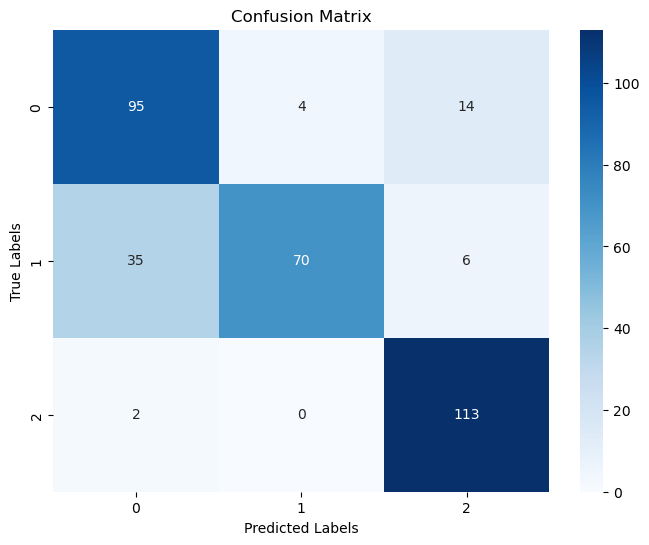

In [21]:
#THIS WORKS, DON'T TOUCH!!!!! - DONT MOVE, KEEP IT RIGHT IN THIS POSITION

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

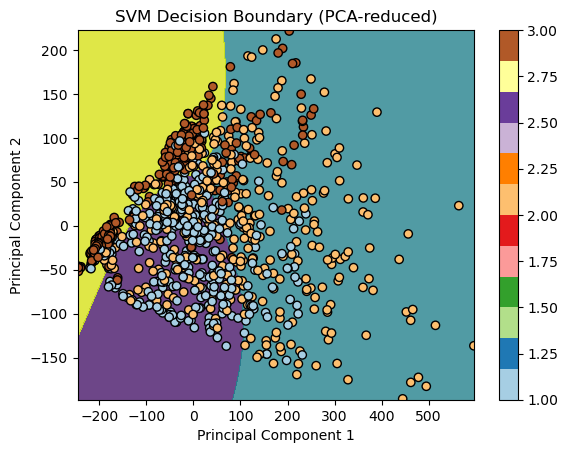

In [10]:
# MORE VIS 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Assuming X_train (images) and y_train (labels) are prepared

# Flatten images into vectors (assuming X_train is a numpy array of shape (n_samples, 128, 128))
n_samples = X_train.shape[0]
X_train_flat = X_train.reshape(n_samples, -1)  # Reshape to (n_samples, 16384)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
X_train_pca = pca.fit_transform(X_train_flat)

# Split data into training and validation sets
X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

# Initialize SVM classifier with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)

# Train SVM model on PCA-transformed data
svm_model.fit(X_train_pca, y_train)

# Plot decision boundary in the reduced PCA space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary (PCA-reduced)')
plt.colorbar()
plt.show()

# Visualize ROC curve - Multi-Class

C:\Users\embilab\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


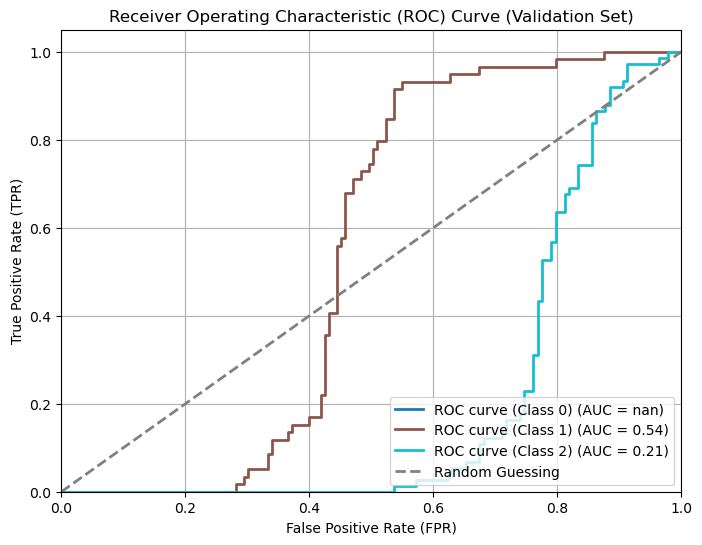

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'images' and 'labels' are the loaded data
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the SVM model with RBF kernel and probability=True for obtaining class probabilities
svm_model = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)

# Train the SVM model
svm_model.fit(X_train.reshape(len(X_train), -1), y_train)

# Get predicted probabilities for each class on the validation set
y_val_prob = svm_model.predict_proba(X_val.reshape(len(X_val), -1))

# Compute ROC curve and AUC for each class
n_classes = len(np.unique(labels))  # Number of unique classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_val == i).astype(int), y_val_prob[:, i])  # Use one-vs-all ROC
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))  # Get an array of colors from 'tab10' colormap
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (Class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





# Visualize ROC Curve using aggregated data

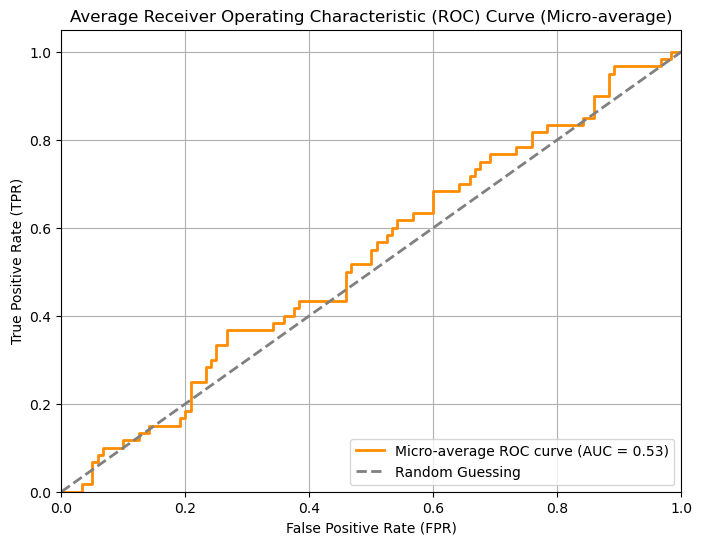

In [48]:
# Generate sample data (replace this with your data loading and preprocessing)
np.random.seed(42)
n_samples = 300
n_classes = 3
X = np.random.randn(n_samples, 10)  # Sample features
y = np.random.randint(0, n_classes, size=n_samples)  # Sample multiclass labels

# Binarize the labels (one-hot encoding for multiclass)
y_bin = label_binarize(y, classes=np.arange(n_classes))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Initialize the SVM classifier with RBF kernel
svm_model = OneVsRestClassifier(SVC(kernel='rbf', probability=True, random_state=42))

# Train the model
svm_model.fit(X_train, y_train)

# Get predicted probabilities for each class
y_score = svm_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the average ROC curve across all classes
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Average Receiver Operating Characteristic (ROC) Curve (Micro-average)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Train the SVM model with RBF kernel
svm_model_rbf = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model_rbf.fit(X_train.reshape(len(X_train), -1), y_train)

# Make predictions on the testing set
y_test_pred_rbf = svm_model_rbf.predict(X_test.reshape(len(X_test), -1))

# Calculate evaluation metrics
accuracy_rbf = accuracy_score(y_test, y_test_pred_rbf)
precision_rbf = precision_score(y_test, y_test_pred_rbf, average='weighted')
recall_rbf = recall_score(y_test, y_test_pred_rbf, average='weighted')
jaccard_index_rbf = jaccard_score(y_test, y_test_pred_rbf, average='weighted')
f1_score_rbf = f1_score(y_test, y_test_pred_rbf, average='weighted')
conf_matrix_rbf = confusion_matrix(y_test, y_test_pred_rbf)
tn_rbf = conf_matrix_rbf[0, 0]
fp_rbf = conf_matrix_rbf[0, 1:].sum()
fn_rbf = conf_matrix_rbf[1:, 0].sum()
dice_similarity_rbf = (2 * tn_rbf) / (2 * tn_rbf + fp_rbf + fn_rbf)
specificity_rbf = tn_rbf / (tn_rbf + fp_rbf)

# Print the computed evaluation metrics
print("Evaluation Metrics for SVM with RBF kernel:")
print("Accuracy:", accuracy_rbf)
print("Precision:", precision_rbf)
print("Recall (Sensitivity):", recall_rbf)
print("Jaccard Index:", jaccard_index_rbf)
print("F1 Score:", f1_score_rbf)
print("Dice Similarity:", dice_similarity_rbf)
print("Specificity:", specificity_rbf)

In [ ]:
# Initialize lists to store precision, recall, and thresholds for each class
precisions = []
recalls = []
thresholds = []
num_classes = 3

# Compute precision-recall curve for each class
for class_label in range(num_classes):
    precision, recall, threshold = precision_recall_curve((y_val == class_label), y_scores[:, class_label])
    precisions.append(precision)
    recalls.append(recall)
    thresholds.append(threshold)

# Plot Precision-Recall curves for each class
plt.figure(figsize=(8, 6))
for class_label in range(num_classes):
    plt.plot(recalls[class_label], precisions[class_label], label=f"Class {class_label}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()